# 2. 使用二分k-means 算法对地图上的点聚类
使用places.txt 文件中地图上的点的纬度和经度数据（第4 列、第5 列），采用二分k-means 对地图上的点聚类（k 设定为5）。

[[-122.52285415   45.46830786]
 [-122.70552458   45.48026276]]
[[-122.54894327   45.51554093]
 [-122.69531692   45.50981882]]
[[-122.54868607   45.51882187]
 [-122.69551477   45.50729503]]
sseSplit, and notSplit: 3043.2633161055337 0.0
the bestCentToSplit is: 0
the len of bestClustAss is: 69
[[-122.52127292   45.54546061]
 [-122.47206386   45.44340293]]
[[-122.55932296   45.52407389]
 [-122.452954     45.47155367]]
[[-122.56208315   45.52250274]
 [-122.42811233   45.485694  ]]
sseSplit, and notSplit: 511.80653761865034 2191.824427523823
[[-122.76071969   45.57351539]
 [-122.74830491   45.39114158]]
[[-122.69806097   45.53039607]
 [-122.6881308    45.440302  ]]
sseSplit, and notSplit: 1441.0506991429631 851.4388885817106
the bestCentToSplit is: 1
the len of bestClustAss is: 39
[[-122.57039859   45.49721088]
 [-122.5588367    45.43174343]]
[[-122.55463028   45.52187369]
 [-122.376304     45.430319  ]]
[[-122.55924018   45.52238271]
 [-122.4009285    45.46897   ]]
sseSplit, and notSplit: 

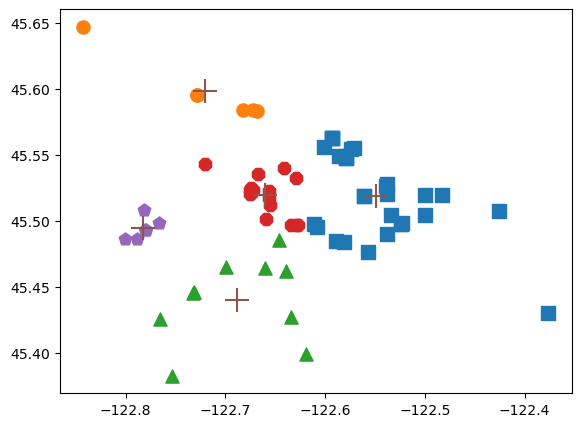

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def distEclud(vecA,vecB):
    return np.sqrt(np.sum(np.power(vecA-vecB,2)))

def randCent(dataSet,k):
    n=np.shape(dataSet)[1]
    centroids=np.mat(np.zeros((k,n)))
    for j in range(n):
        minJ=np.min(dataSet[:,j])
        rangeJ=float(np.max(dataSet[:,j])-minJ)
        centroids[:,j]=minJ+rangeJ*np.random.rand(k,1)
    return centroids

def kMeans(dataSet,k,distMeas=distEclud,createCent=randCent):
    m=np.shape(dataSet)[0]
    clusterAssment=np.mat(np.zeros((m,2)))
    centroids=createCent(dataSet,k)
    clusterChanged=True
    while clusterChanged:
        clusterChanged=False
        for i in range(m):
            minDist=np.inf
            minIndex=-1
            for j in range(k):
                distJI=distMeas(centroids[j,:],dataSet[i,:])
                if distJI<minDist:
                    minDist=distJI
                    minIndex=j
            if clusterAssment[i,0]!=minIndex:
                clusterChanged=True
            clusterAssment[i,:]=minIndex,minDist**2
        print(centroids)
        for cent in range(k):
            ptsInClust=dataSet[np.nonzero(clusterAssment[:,0].A==cent)[0]]
            centroids[cent,:]=np.mean(ptsInClust,axis=0)
    return centroids,clusterAssment

def biKmeans(dataSet,k,distMeas=distEclud):
    m=np.shape(dataSet)[0]
    clusterAssment=np.mat(np.zeros((m,2)))
    centroid0=np.mean(dataSet,axis=0).tolist()[0]
    centList=[centroid0]
    for j in range(m):
        clusterAssment[j,1]=distMeas(np.mat(centroid0),dataSet[j,:])**2
    while len(centList)<k:
        lowestSSE=np.inf
        for i in range(len(centList)):
            ptsInCurrCluster=dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:]
            centroidMat,splitClustAss=kMeans(ptsInCurrCluster,2,distMeas)
            sseSplit=np.sum(splitClustAss[:,1])
            sseNotSplit=np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A!=i)[0],1])
            print('sseSplit, and notSplit:',sseSplit,sseNotSplit)
            if (sseSplit+sseNotSplit)<lowestSSE:
                bestCentToSplit=i
                bestNewCents=centroidMat
                bestClustAss=splitClustAss.copy()
                lowestSSE=sseSplit+sseNotSplit
        bestClustAss[np.nonzero(bestClustAss[:,0].A==1)[0],0]=len(centList)
        bestClustAss[np.nonzero(bestClustAss[:,0].A==0)[0],0]=bestCentToSplit
        print('the bestCentToSplit is:',bestCentToSplit)
        print('the len of bestClustAss is:',len(bestClustAss))
        centList[bestCentToSplit]=bestNewCents[0,:]
        centList.append(bestNewCents[1,:])
        clusterAssment[np.nonzero(clusterAssment[:,0].A==bestCentToSplit)[0],:]=bestClustAss
    centList=list(map(lambda x:[x[0],x[1]],[np.matrix.tolist(i)[0] for i in centList]))
    return np.mat(centList),clusterAssment       

def distSLC(vecA,vecB):
    a=np.sin(vecA[0,1]*np.pi/180)*np.sin(vecB[0,1]*np.pi/180)
    b=np.cos(vecA[0,1]*np.pi/180)*np.cos(vecB[0,1]*np.pi/180)*np.cos(np.pi*(vecB[0,0]-vecA[0,0])/180)
    return np.arccos(a+b)*6371.0

def clusterClubs(numClust=5):
    datList=[]
    for line in open('places.txt').readlines():
        lineArr=line.split('\t')
        datList.append([float(lineArr[4]),float(lineArr[3])])
    datMat=np.mat(datList)
    myCentroids,clustAssing=biKmeans(datMat,numClust,distMeas=distSLC)
    fig=plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s','o' ,'^','8','p','d','v','h','>','<']
    axprops=dict(xticks=[],yticks=[])
    ax0=fig.add_axes(rect,label='ax0',**axprops)
    # imgP=plt.imread('Portland.png')
    # ax0.imshow(imgP)
    ax1=fig.add_axes(rect,label='ax1',frameon=False)
    for i in range(numClust):
        ptsInCurrCluster=datMat[np.nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle=scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0],ptsInCurrCluster[:,1].flatten().A[0],marker=markerStyle,s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0],myCentroids[:,1].flatten().A[0],marker='+',s=300)
    plt.show()
    
clusterClubs()